# Figure 4F, 5 and S12

This program is used for histograms and scatter plot of deletion experiments with ribosome reporter strain.

## Figure 4F and S12
### import python packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import scipy.stats as stat
import os
from common_function import singlecell as sc

### Matplotlib setting

In [2]:
plt.rcParams['text.usetex'] = True 
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams["font.size"] = 16

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

### set variables for data import and calculation

In [3]:
fluorescence1 = 'TxRed'#'TxRed' or 'YFP'
fluorescence2 = 'YFP'#'TxRed' or 'YFP'

dr = './single-cell_data/ribosome_reporter/YK0136/'
data_list136 = os.listdir(dr)
if '.DS_Store' in data_list136:
    data_list136.remove('.DS_Store')
dr138 = './single-cell_data/ribosome_reporter/YK0138/'
data_list138 = os.listdir(dr138)
if '.DS_Store' in data_list138:
    data_list138.remove('.DS_Store')
    
BL_time_Cp_time_list = pd.read_csv('./BL_time_Cp_time_data.csv')

### import data and integration

import and integrate data of experiments with YK0136 and YK0138.
And calculate the fluorescence ratio.

In [4]:
Total_Results = pd.DataFrame(index = [], columns = ['id_number','Time', fluorescence1, fluorescence2, 'ratio'])
for day in data_list136:
    BL_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(day), 'BL_time'].reset_index(drop = True)[0] ## slice number just after blue light exposure
    
    Number = os.listdir(dr+day+'/integrated')
    Number = [i for i in Number if 'Results' in i]
    for i in range(len(Number)):
        Number[i] = Number[i].lstrip('Result')
        Number[i] = Number[i].rstrip('.csv')

    Results = pd.concat([pd.read_csv(dr + day + '/integrated/Results'+str(i).zfill(4)+'.csv', encoding = 'shift_jis') for i in Number])
    Results = sc.preprocessing(Results, BL_time)
    Total_Results = pd.concat([Total_Results,Results])
    
for day in data_list138:
    Cp_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(day), 'Cp_time'].reset_index(drop = True)[0] ## slice number just after Cp exposure
    Number = os.listdir(dr138+day+'/integrated')
    Number = [i for i in Number if 'Results' in i]
    for i in range(len(Number)):
        Number[i] = Number[i].lstrip('Result')
        Number[i] = Number[i].rstrip('.csv')

    Results = pd.concat([pd.read_csv(dr138 + day + '/integrated/Results'+str(i).zfill(4)+'.csv', encoding = 'shift_jis') for i in Number])
    Results = sc.preprocessing(Results, Cp_time)
    Total_Results = pd.concat([Total_Results,Results])

### set variables for figure plotting

In [5]:
bin_wid = 22
range_list = [0,5.5]
time_list = [-1, 0, 10, 30, 50, 65]
color_list = ['tomato','limegreen','royalblue','grey']
legend_list = ['Non-deleted\ncell lineages', 'Resistance-gene-\ndeleted cell lineages\n(growth-halted)',\
               'Resistance-gene-\ndeleted cell lineages\n(growth-restored)','Pre-deleted\ncell lineages']

### plot figures and save

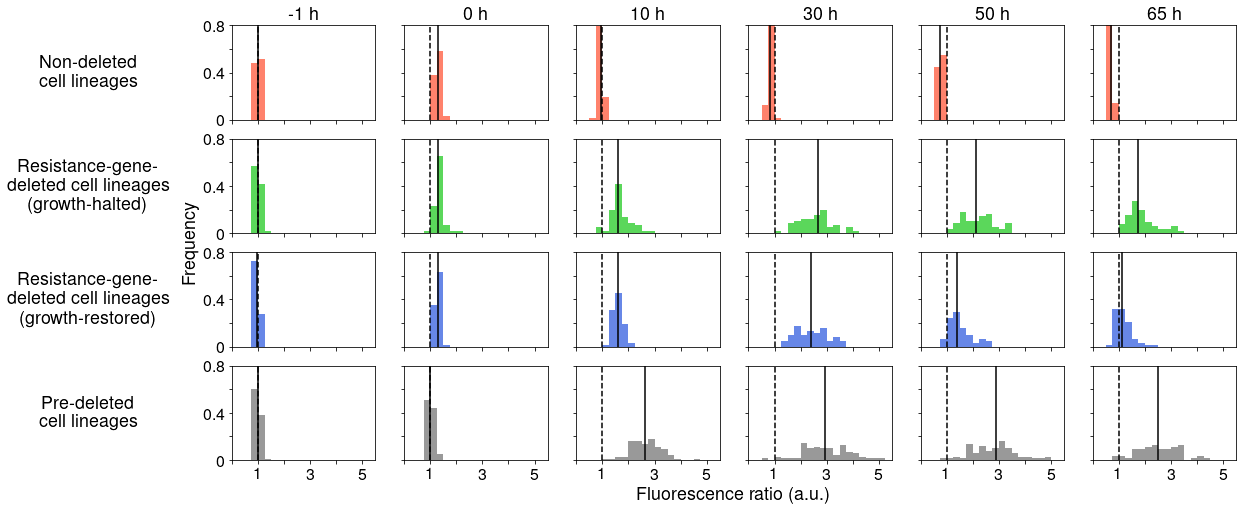

In [6]:
fig, axes = plt.subplots(nrows=4, ncols=6, sharex = True, sharey = True, figsize = (18,8))
for i, time in enumerate(time_list):
    for num, j in enumerate([2,1,0,3]):
        weights = np.ones(len(Total_Results[(Total_Results['Time']==time)&(Total_Results['id_number'] == j)]['ratio']))/float(len(Total_Results[(Total_Results['Time']==time)&(Total_Results['id_number'] == j)]['ratio']))
        Total_Results[(Total_Results['Time']==time)&(Total_Results['id_number'] == j)]['ratio'].hist(bins = bin_wid, weights = weights, range = range_list, ax=axes[num,i], alpha = 0.8, color = color_list[num])
        axes[num,i].vlines(Total_Results[(Total_Results['Time']==time)&(Total_Results['id_number'] == j)]['ratio'].median(), 0, 0.8)
        axes[num,i].vlines(1, 0, 0.8, linestyles = 'dashed')
        axes[num,i].grid(False)
        if i == 0:
            axes[num,i].set_yticks([0,0.2,0.4,0.6,0.8])
            axes[num,i].set_yticklabels([0,'',0.4,'',0.8])
            axes[num,i].text(-1.0,0.5,legend_list[j],va = 'center', ha = 'center', transform=axes[j,0].transAxes, fontsize = 18)
    title = str(time) + ' h'
    axes[0,i].set_title(title, fontsize = 18)
    axes[3,i].set_xticks([0,1,2,3,4,5])
    axes[3,i].set_xticklabels(['',1,'',3,'',5])
plt.xlim(range_list)
plt.ylim(0,0.8)


# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Fluorescence ratio (a.u.)', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)
plt.show()
#plt.savefig('./Figure4F.pdf', transparent = True, bbox_inches = 'tight')
#plt.cla()

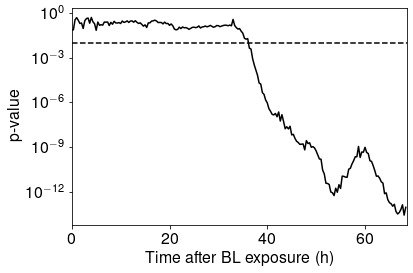

In [7]:
Time_array = np.arange(0,68.5,1/3)
pvalue_list = []
for time in Time_array:
    pvalue_list += [stat.mannwhitneyu(Total_Results[(np.isclose(Total_Results['Time'],time))&(Total_Results['id_number'] == 0)]['ratio'],Total_Results[(np.isclose(Total_Results['Time'],time))&(Total_Results['id_number'] == 1)]['ratio'])[1]]

plt.plot(Time_array, pvalue_list, color = 'black')
plt.yscale('log')
plt.hlines(0.01,0,68.5, linestyle = 'dashed')
plt.ylabel('p-value')
plt.xlabel('Time after BL exposure (h)')
plt.xlim(0,68.5)
plt.show()
# save_path = './FigureS12.pdf'
# plt.savefig(save_path, transparent = True, bbox_inches = 'tight')

In [8]:
data = {'Time': Time_array, 'p-value': pvalue_list}
df = pd.DataFrame(data)
# save_data = './ratio_pvalue.csv'
# df.to_csv(save_data)
print('p-value at 50 h is {:.1e}, and p-value at 65 h is {:.1e}.'.format(df.loc[df['Time'] == 50,'p-value'].values[0],df.loc[df['Time'] == 65,'p-value'].values[0]))


p-value at 50 h is 5.6e-10, and p-value at 65 h is 1.9e-13.


## Figure 5

### set variables

In [9]:
dir136 = './single-cell_data/ribosome_reporter/YK0136/191214/integrated'
dir138 = './single-cell_data/ribosome_reporter/YK0138/191218/integrated'

fluorescence1 = 'TxRed'
fluorescence2 = 'YFP'
BL_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(dir136[-17:-11]), 'BL_time'].reset_index(drop = True)[0]
Cp_time = BL_time_Cp_time_list.loc[BL_time_Cp_time_list['Date'] == int(dir138[-17:-11]), 'Cp_time'].reset_index(drop = True)[0]
rate = 'Fluorescence ratio'
rate2 = 'Elongation_rate'

### import result data and calculate the normalized term

In [10]:
### import and concatnate data in experiment with YK0136
Number = os.listdir(dir136)
Number = [i for i in Number if 'Results' in i]
for i in range(len(Number)):
    Number[i] = Number[i].lstrip('Result')
    Number[i] = Number[i].rstrip('.csv')
Number_d = [s for s in Number if s[2] == '0']

Number_dd =[s for s in Number if s[2] == '1']

Number_nd= [s for s in Number if s[2] == '2']
Result_d_all = pd.concat([pd.read_csv(dir136+'/Results'+str(i).zfill(4)+'.csv', encoding = 'shift_jis') for i in Number_d])
Result_d_all['Label'] = 0
Result_nd_all = pd.concat([pd.read_csv(dir136+'/Results'+str(i).zfill(4)+'.csv', encoding = 'shift_jis') for i in Number_nd])
Result_nd_all['Label'] = 2
Result_dd_all = pd.concat([pd.read_csv(dir136+'/Results'+str(i).zfill(4)+'.csv', encoding = 'shift_jis') for i in Number_dd])
Result_dd_all['Label'] = 1
Result = pd.concat([Result_d_all, Result_nd_all, Result_dd_all])
Result['Time'] = (Result['Slice']-BL_time)/6
Result = Result[(Result['Time']<-1/2)|(Result['Time']>=0)]
Result = Result[Result['Slice']!=215]
Result.loc[Result['Slice']>=306,'Time']+=1/2

###calculate normalized fluorescence ratio
Result[rate]=Result[fluorescence1]/Result[fluorescence2]
Result2 = Result[['Time',rate,'Label']].dropna().copy()
Mean_FL_rate = Result2[Result2['Time']<-0.5][rate].mean()
Result2[rate] /= Mean_FL_rate

### import data in experiment with YK0138
Number_ad = os.listdir(dir138)
Number_ad = [i for i in Number_ad if 'Results' in i]
for i in range(len(Number_ad)):
    Number_ad[i] = Number_ad[i].lstrip('Result')
    Number_ad[i] = Number_ad[i].rstrip('.csv')
Result = pd.concat([pd.read_csv(dir138+'/Results'+str(i).zfill(4)+'.csv', encoding = 'shift_jis') for i in Number_ad])
Result['Label'] = 3
Result['Time'] = (Result['Slice']-Cp_time)/6

### calculate fluorescence ratio
Result[rate]=Result[fluorescence1]/Result[fluorescence2]
Result3 = Result[['Time',rate,'Label']].dropna().copy()
Mean_FL_rate_ad = Result3[Result3['Time']<-0.5][rate].mean()
Result3[rate] /= Mean_FL_rate_ad

### calculate the width of fluorescence ratio in non-deleted cell lineages before BL illumination

In [11]:
Result2_ndiv = Result2.loc[Result2['Label'] == 2]
Mean = Result2_ndiv.loc[(Result2_ndiv['Time']<=-0.5),rate].mean()
SD = Result2_ndiv.loc[(Result2_ndiv['Time']<=-0.5),rate].std()
Min = Mean - 1.96*SD
Max = Mean + 1.96*SD

print('The ratio before BL illumitaion is within a narrow range ({:.2f}-{:.2f}, 95% interval)'.format(Min,Max))

The ratio before BL illumitaion is within a narrow range (0.84-1.18, 95% interval)


### calculate 2-h averaged elongation rate and fluorescence ratio

In [12]:
Result_div = pd.DataFrame(data = {'Time':[], rate:[],rate2:[]})
for i in Number_d:
    Result = pd.read_csv(dir136+'/Results'+str(i).zfill(4)+'.csv', encoding = 'shift_jis')
    Resultc = sc.Single_Result_time_elongation_fluorescence_ratio(Result, BL_time, Mean_FL_rate, rate = rate, rate2 = rate2)
    Result_div = pd.concat([Result_div, Resultc])

Result_ddiv = pd.DataFrame(data = {'Time':[], rate:[],rate2:[]})
for i in Number_dd:
    Result = pd.read_csv(dir136+'/Results'+str(i).zfill(4)+'.csv', encoding = 'shift_jis')
    Resultc = sc.Single_Result_time_elongation_fluorescence_ratio(Result, BL_time, Mean_FL_rate, rate = rate, rate2 = rate2)
    Result_ddiv = pd.concat([Result_ddiv, Resultc])

Result_ndiv = pd.DataFrame(data = {'Time':[], rate:[],rate2:[]})
for i in Number_nd:
    Result = pd.read_csv(dir136+'/Results'+str(i).zfill(4)+'.csv', encoding = 'shift_jis')
    Resultc = sc.Single_Result_time_elongation_fluorescence_ratio(Result, BL_time, Mean_FL_rate, rate = rate, rate2 = rate2)
    Result_ndiv = pd.concat([Result_ndiv, Resultc])

Result_adiv = pd.DataFrame(data = {'Time':[], rate:[],rate2:[]})
for i in Number_ad:
    Result = pd.read_csv(dir138 + '/Results'+str(i).zfill(4)+'.csv', encoding = 'shift_jis')
    Resultc = sc.Single_Result_time_elongation_fluorescence_ratio(Result, Cp_time, Mean_FL_rate_ad, rate = rate, rate2 = rate2, YK0136=False)
    Result_adiv = pd.concat([Result_adiv, Resultc])
            
Result_d = Result_div.loc[Result_div['Time']>=0,:].copy()
Result_d.loc[:,'cell'] = 0
Result_dd = Result_ddiv.loc[Result_ddiv['Time']>=0,:].copy()
Result_dd.loc[:,'cell'] = 1
Result_ad = Result_adiv.loc[Result_adiv['Time']>=0,:].copy()
Result_ad.loc[:,'cell'] = 3
Result_nd = Result_ndiv.loc[Result_ndiv['Time']>=0,:].copy()
Result_nd.loc[:,'cell'] = 2
Result = pd.concat([Result_d, Result_dd, Result_ad,Result_nd])

### plot and save figure

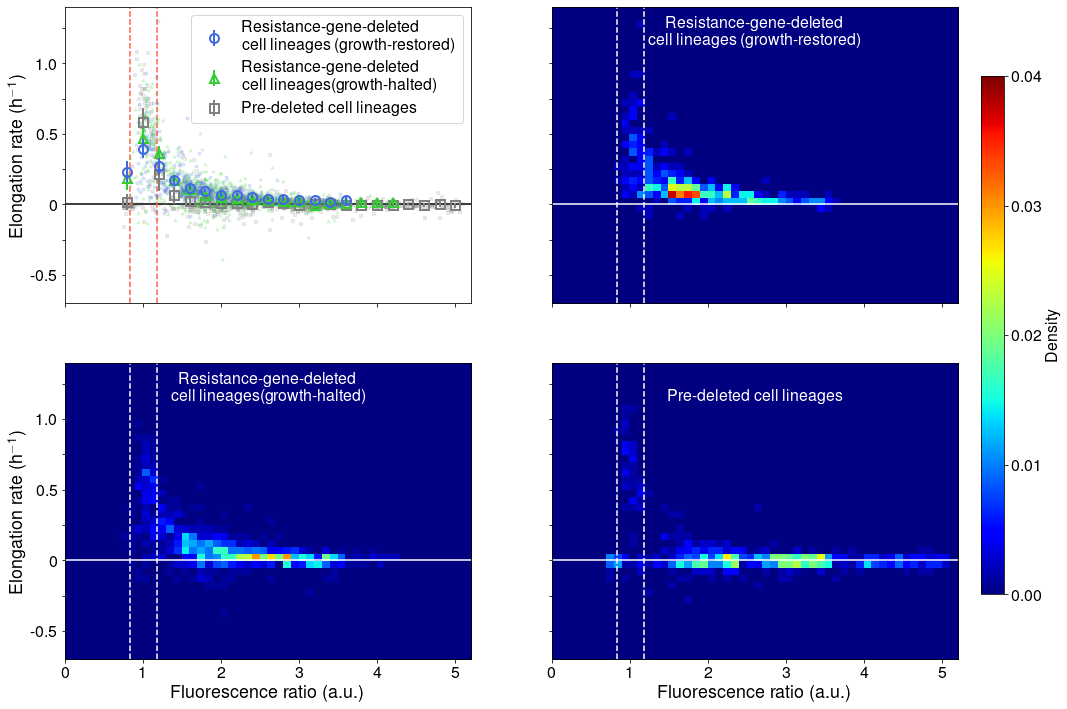

In [13]:
import matplotlib.cm as cm

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (16,12), sharex = True, sharey = True)

bins_list = list(np.arange(-0.1,5.3,0.2))
color_list = ['royalblue','limegreen','grey']
marker_list = ['o','^','s']
label_list = ['Resistance-gene-deleted \ncell lineages (growth-restored)', 'Resistance-gene-deleted \ncell lineages(growth-halted)','Pre-deleted cell lineages']

for i, name in enumerate([0,1,3]):
    Result2_d = Result.loc[Result.loc[:,'cell'] == name].copy()
    cut = pd.cut(Result2_d.loc[:,rate],bins = bins_list,labels = False)
    Result2_d.loc[:,'cut'] = cut/5.0
    Result2_d = Result2_d.dropna(subset = ['cut'])
    weights = np.ones(len(Result2_d[rate]))/len(Result2_d[rate])
    axes[(i+1)//2,(i+1)%2].fill_between((0,5.2),(-0.7,-0.7),(1.4,1.4),color = 'navy')
    axes[0,0].plot(Result2_d[rate],Result2_d[rate2], label = None, lw = 0, marker = marker_list[i], markersize = 3, color = color_list[i], alpha = 0.15,zorder = 3-i)
    H = axes[(i+1)//2,(i+1)%2].hist2d(Result2_d[rate],Result2_d[rate2], bins = [np.linspace(0,5.2,53),np.linspace(-0.7,1.4,43)], cmap = 'jet', weights = weights,vmin = 0, vmax = 0.04)
    Result2_des = Result2_d.dropna(subset = ['cut']).groupby('cut').describe()[rate2].reset_index()
    Result2_des['se'] = Result2_des['std']/Result2_des['count']**0.50
    axes[0,0].errorbar(Result2_des['cut'], Result2_des['mean'], yerr = Result2_des['se']*1.96, lw = 2, ls = '', marker = marker_list[i], markersize = 9, markeredgewidth = 2, markerfacecolor = 'none', markeredgecolor = color_list[i], ecolor = color_list[i],label = label_list[i],zorder = 7-i)
    #axes[(i+1)//2,(i+1)%2].errorbar(Result2_des['cut'], Result2_des['mean'], yerr = Result2_des['se']*1.96, lw = 2, ls = '', marker = marker_list[i], markersize = 9, markeredgewidth = 2, markerfacecolor = 'none', markeredgecolor = color_list[i], ecolor = color_list[i],label = label_list[i],zorder = 7-i)
    #plt.colorbar(H[3],ax = axes[(i+1)//2,(i+1)%2])
    

for k in np.arange(0,4,1):
    axes[0,0].legend()

    axes[1, k%2].set_xlim(0,5.2)
    axes[k//2, 0].set_ylim(-0.7,1.4)
    axes[1, k%2].set_xticks([0,1,2,3,4,5])
    axes[1, k%2].set_xticklabels(['0','1','2','3','4','5'])
    axes[k//2, 0].set_yticks([-0.5,-0.25,0,0.25,0.5,0.75,1.0,1.25])
    axes[k//2, 0].set_yticklabels([-0.5,'',0,'',0.5,'',1.0,''])
    axes[k//2, k%2].set_title('')
    axes[k//2, k%2].hlines(0,0,5.2,color = 'white')
    axes[k//2, k%2].vlines(Min,-0.7,1.4,ls = '--',color = 'white')
    axes[k//2, k%2].vlines(Max,-0.7,1.4,ls = '--',color = 'white')
    if k == 0:
        axes[k//2, k%2].hlines(0,0,5.2,color = 'black')
        axes[k//2, k%2].vlines(Min,-0.7,1.4,ls = '--',color = 'tomato')
        axes[k//2, k%2].vlines(Max,-0.7,1.4,ls = '--',color = 'tomato')
    axes[1, k%2].set_xlabel('Fluorescence ratio (a.u.)',fontsize = 18)
    axes[k//2, 0].set_ylabel('Elongation rate (h$^{-1}$)',fontsize = 18)
    axes[k//2, k%2].grid(False)
    if k > 0:
        axes[k//2,k%2].set_title(label_list[k-1],y = 0.85,fontsize = 16, color = 'white')
fig.suptitle('')
ax = fig.add_axes([0.92,0.2,0.02,0.6])
fig.colorbar(H[3],cax = ax, ticks = [0,0.01,0.02,0.03, 0.04], label = 'Density')#
plt.show()
#plt.savefig('./Figure5.pdf', transparent=True, bbox_inches = 'tight')
#plt.cla()

### calculate the spearman rho and its confidence interval.

In [14]:
r,p = stat.spearmanr(Result.loc[Result.loc[:,'cell'] != 2,rate],Result.loc[Result.loc[:,'cell'] != 2,rate2],nan_policy='omit')
z_r = math.log((1+r)/(1-r))/2
z_L = z_r - 1.96*math.sqrt((1+r**2/2)/(len(Result.loc[Result.loc[:,'cell'] == i,rate])-3))
z_U = z_r + 1.96*math.sqrt((1+r**2/2)/(len(Result.loc[Result.loc[:,'cell'] == i,rate])-3))

r_L = (math.exp(2*z_L)-1)/(math.exp(2*z_L)+1)
r_U = (math.exp(2*z_U)-1)/(math.exp(2*z_U)+1)

print('spearmann rho = {:.2f}; 95% confidence interval [{:.2f},{:.2f}]'.format(r, r_L, r_U))

spearmann rho = -0.58; 95% confidence interval [-0.62,-0.53]
